In [1]:
import numpy as np # includes lots of useful maths funcitons
import matplotlib.pyplot as plt # package for plotting
import scipy.integrate as integrate # package for numerical integration
from scipy.special import gamma, factorial # gamma function and factorial
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde

 # PART 1
 Choose two reasonably separated values of the tail index, say alpha_1 = 1.3, and alpha_2 = 1.7. Let X1 be the symmetric stable Paretian random variable (with location zero and scale 1) with alpha1; and X2 be the same, for alpha2; and these are *independent*. For a smart range of x-values (e.g., -8 to 8; but you check the plots and choose), compute:

In [29]:
alpha_1 = 1.3
alpha_2 = 1.7
x_line = np.linspace(-10, 10, 100)

In [30]:
def cf_symmetric_stable_paretian(t, alpha):
    return np.exp(-abs(t) ** alpha)

### a) using the integral convolution formula (and a program to compute the pdf of the stable), the density of the convolution of X1 and X2, i.e., of S=X1+X2.

We use built in levy stable function.

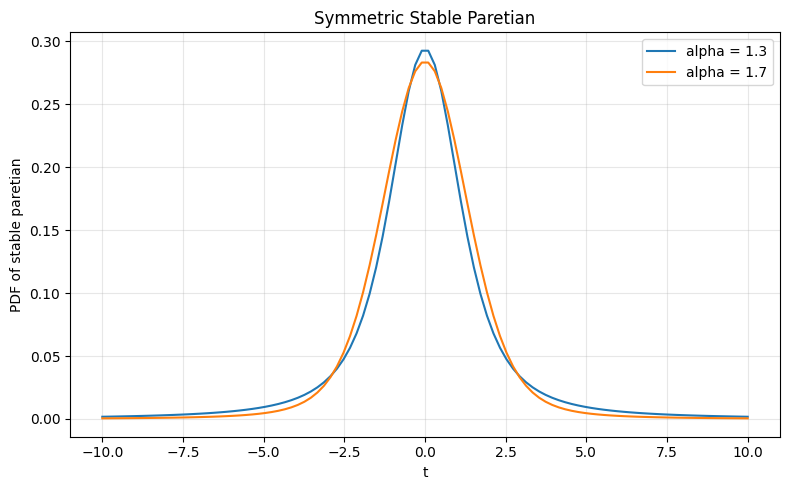

In [31]:
# compute cfs
phi_1 = levy_stable.pdf(x_line, alpha_1, 0)
phi_2 = levy_stable.pdf(x_line, alpha_2, 0)


# plot
plt.figure(figsize=(8, 5))
plt.plot(x_line, phi_1, label=f'alpha = {alpha_1}')
plt.plot(x_line, phi_2, label=f'alpha = {alpha_2}')
plt.xlabel('t')
plt.ylabel('PDF of stable paretian')
plt.title('Symmetric Stable Paretian')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Graph density of S = X1 + X2

In [32]:
def integrand(x1, s, alpha1, alpha2):
    return levy_stable.pdf(x1, alpha1, 0) * levy_stable.pdf(s - x1, alpha2, 0)

In [33]:
def convolution_pdf(s, alpha_1, alpha_2, integration_cutoff = np.inf):
    return integrate.quad(integrand, -integration_cutoff, integration_cutoff, args=(s, alpha_1, alpha_2))

In [34]:
# ---- vectorize it ----
conv_pdf_vec = np.vectorize(lambda s: convolution_pdf(s, alpha_1, alpha_2)[0])

# Example usage
y = conv_pdf_vec(x_line)

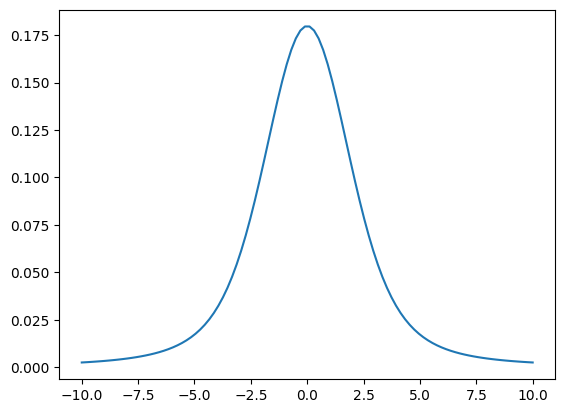

In [35]:
plt.plot(x_line,y)

# Part b)

In [36]:
sim_size = 100000
sample_1 = levy_stable.rvs(alpha_1, 0, size = sim_size)
sample_2 = levy_stable.rvs(alpha_2, 0, size = sim_size)

sample_convolution = sample_1 + sample_2

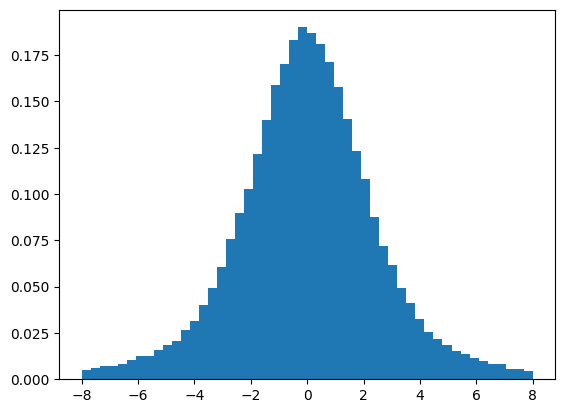

In [37]:
plt.hist(sample_convolution, bins = 50, range = (-8, 8), density=True);

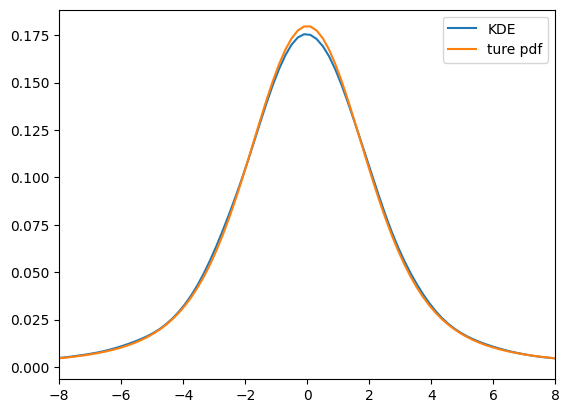

In [38]:
# 1. Fit KDE
kde = gaussian_kde(sample_convolution, bw_method=0.01) 
# Bandwidth should be small because the variance is infinity, but we don't want to go too far to get a smooth kernel

# 2. Evaluate on a grid
kde_vals = kde(x_line)

# 3. Plot
plt.plot(x_line, kde_vals, label='KDE')
plt.plot(x_line,y, label = "ture pdf")

#plt.hist(sample, bins=30, density=True, alpha=0.5, label='Histogram')
plt.xlim(right=8)  # adjust the right leaving left unchanged
plt.xlim(left=-8) 
plt.legend()

plt.show()


# Part c

c) As X1 and X2 are independent, the characteristic function of the sum, S=X1+X2, is trivial. Use the inversion formula applied to the ch.f. of S to compute its density.

In [39]:
def cf_s(t, alpha1, alpha2):
    return cf_symmetric_stable_paretian(t, alpha1) * cf_symmetric_stable_paretian(t, alpha2)

In [40]:
def integrand_inversion_formula(t, x, alpha1, alpha2):
    return np.cos(t * x) * cf_s(t, alpha1, alpha2)

In [41]:
def pdf_inversion_cf(x, alpha1, alpha2):
    # FIX 3: Pass alpha1 and alpha2 into args so the integrand receives them
    # FIX 2: Access [0] because quad returns (integral, error)
    integral_val = integrate.quad(
        integrand_inversion_formula, 
        -np.inf, 
        np.inf, 
        args=(x, alpha1, alpha2),
        limit=100 
    )[0] 
    
    return (1 / (2 * np.pi)) * integral_val

In [42]:
pdf_inversion_cf

<function __main__.pdf_inversion_cf(x, alpha1, alpha2)>

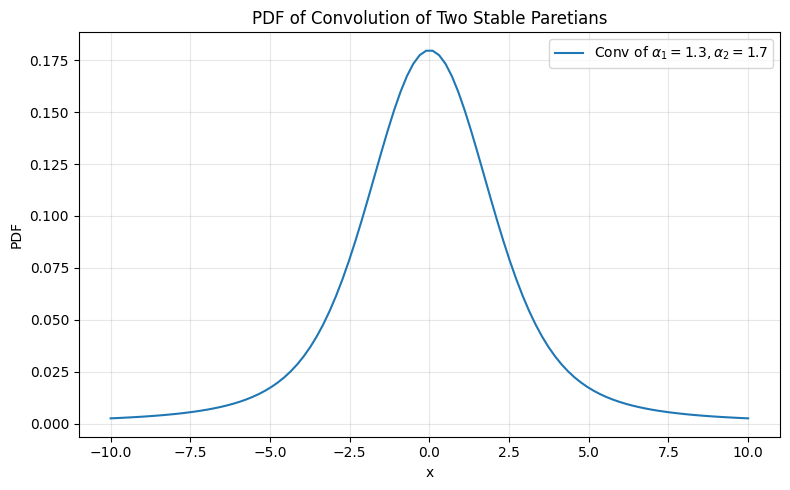

In [43]:
phi_1 = [pdf_inversion_cf(val, alpha_1, alpha_2) for val in x_line]

# plot
plt.figure(figsize=(8, 5))
plt.plot(x_line, phi_1, label=f'Conv of $\\alpha_1={alpha_1}, \\alpha_2={alpha_2}$')
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('PDF of Convolution of Two Stable Paretians')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Part d)

Use the FFT to compute the density of the sum, based on its ch.f. For this, look at my book Intermediate Probability, I think chapter 2, for exactly the required codes to use the FFT to invert the ch.f. to get a density. This is for Matlab --- for Python, you can easily convert my Matlab codes.

In [44]:
def fft_density_calculation(alpha1, alpha2, N=2**14, x_range=20):
    """
    Computes the PDF of the sum of two stable variables using FFT.
    
    Parameters:
    - alpha1, alpha2: Stability parameters.
    - N: Number of grid points (power of 2 is fastest).
    - x_range: The simulation will cover x in [-x_range, x_range].
    """
    
    # 1. Setup the x-grid (Space Domain)
    # We create a grid centered at 0
    L = x_range
    dx = (2 * L) / N
    x = np.arange(-L, L, dx)
    
    # 2. Setup the t-grid (Frequency Domain)
    # The resolution in t is determined by the range in x via Heisenberg uncertainty principle of FFT
    dt = (2 * np.pi) / (N * dx)
    
    # We need t to be centered at 0, corresponding to x
    # The frequency bins usually go: [0, 1, ... N/2-1, -N/2, ... -1] * dt
    # But for calculation clarity, we generate a linear grid and will shift later
    t = np.arange(-N/2, N/2) * dt
    
    # 3. Compute the Characteristic Function of the SUM
    # The CF of a sum of independent variables is the product of their CFs
    vals_1 = cf_symmetric_stable_paretian(t, alpha1)
    vals_2 = cf_symmetric_stable_paretian(t, alpha2)
    cf_sum = vals_1 * vals_2
    
    # 4. Apply FFT to Invert
    # PDF(x) = (1/2pi) * Integral( e^(-itx) * phi(t) dt )
    
    # We use ifftshift to rearrange the array so t=0 is at index 0 (required for standard FFT)
    cf_shifted = np.fft.ifftshift(cf_sum)
    
    # Compute FFT. 
    # Note: numpy's FFT computes sum(y * exp(-2pi...)). 
    # Because Stable distributions are symmetric, FFT and IFFT are essentially the same 
    # up to scaling factors. We use fft here.
    pdf_raw = np.fft.fft(cf_shifted)
    
    # Shift back so x=0 is in the middle of the array
    pdf_shifted = np.fft.fftshift(pdf_raw)
    
    # 5. Normalization
    # The discrete FFT outputs values that scale with N. 
    # We must normalize so that the area under the curve is 1.0
    # Area = sum(pdf) * dx
    current_area = np.sum(np.abs(pdf_shifted)) * dx
    pdf_final = np.abs(pdf_shifted) / current_area
    
    return x, pdf_final

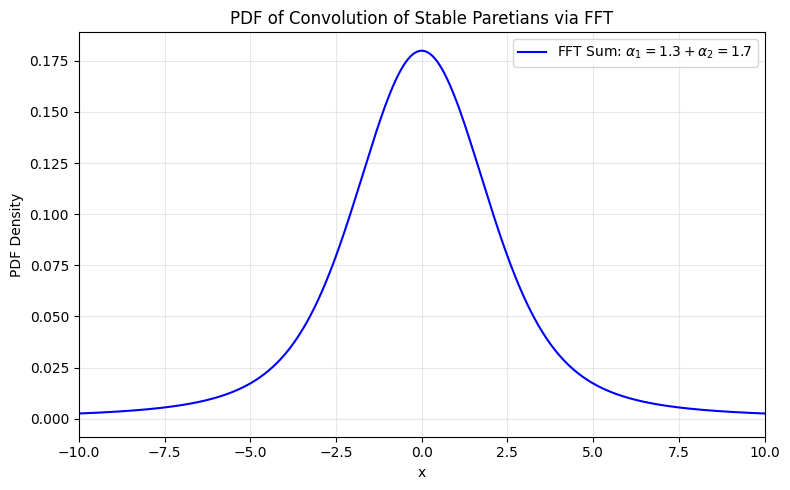

In [45]:
# Run FFT calculation
# Increase x_range if the distribution has very heavy tails
x_fft, pdf_fft = fft_density_calculation(alpha_1, alpha_2, N=16384, x_range=40)

# --- Plotting ---
plt.figure(figsize=(8, 5))

# Plot the FFT result
plt.plot(x_fft, pdf_fft, label=f'FFT Sum: $\\alpha_1={alpha_1} + \\alpha_2={alpha_2}$', color='blue')

plt.xlim(-10, 10) # Zoom in to see the core
plt.xlabel('x')
plt.ylabel('PDF Density')
plt.title('PDF of Convolution of Stable Paretians via FFT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Overlay all the plots on a single graphic, use lovely colors, and add a legend to the graphic so I can see what is what; and be sure to use x- and y-labels, and titles in the plot. (Totally easy with an AI engine, but be sure you could do it on your own!) Note that, if you get everything correct, the densities should all be extremely close.

Make a further plot, same as before, using all 4 methods, but just for the tail, e.g., for x values between, say, 4 and 10.

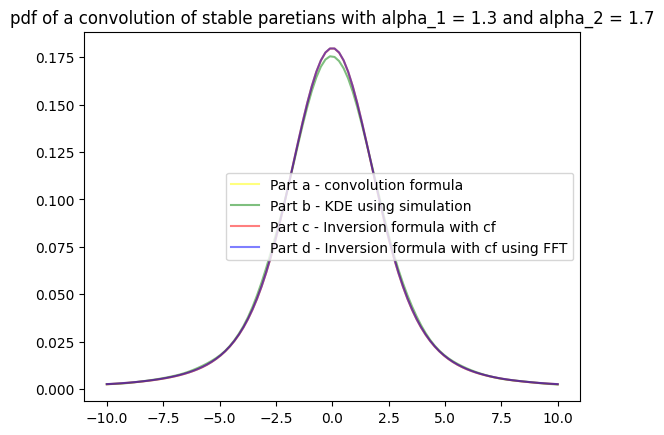

In [64]:
# centered
plt.title("pdf of a convolution of stable paretians with alpha_1 = 1.3 and alpha_2 = 1.7")
plt.plot(x_line,y, label = "Part a - convolution formula", color = "yellow", alpha = 0.5)
plt.plot(x_line, kde_vals, label='Part b - KDE using simulation', color = "green", alpha = 0.5)
plt.plot(x_line, phi_1, label="Part c - Inversion formula with cf", color = "red", alpha = 0.5)

pdf_fft_aligned = np.interp(x_line, x_fft, pdf_fft)
plt.plot(x_line, pdf_fft_aligned, label='Part d - Inversion formula with cf using FFT', color='blue', alpha = 0.5)

plt.legend()
plt.show()

In [56]:
print(y[-30:])

[0.02859257 0.02525447 0.02236246 0.01985897 0.01769159 0.01581355
 0.01418372 0.01276635 0.01153064 0.01045024 0.00950272 0.00866904
 0.00793309 0.00728121 0.00670187 0.00618528 0.00572316 0.00530845
 0.00493515 0.00459814 0.00429302 0.00401602 0.00376389 0.00353383
 0.00332341 0.0031305  0.00295326 0.00279009 0.00263956 0.00250043]


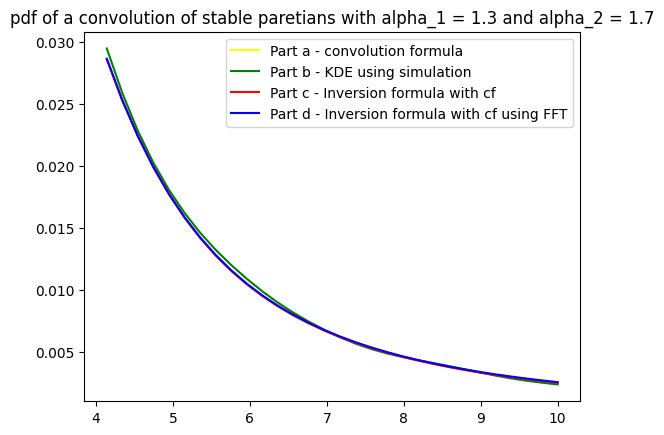

In [65]:
# Tails
x_line_tails = [x for x in x_line if x >= 4]
plt.title("pdf of a convolution of stable paretians with alpha_1 = 1.3 and alpha_2 = 1.7")
plt.plot(x_line_tails,y[-30:], label = "Part a - convolution formula", color = "yellow")
plt.plot(x_line_tails, kde_vals[-30:], label='Part b - KDE using simulation', color = "green")
plt.plot(x_line_tails, phi_1[-30:], label="Part c - Inversion formula with cf", color = "red")

pdf_fft_aligned = np.interp(x_line_tails, x_fft, pdf_fft)
plt.plot(x_line_tails, pdf_fft_aligned[-30:], label='Part d - Inversion formula with cf using FFT', color='blue')

plt.legend()
plt.show()

# PART 2

Via simulation, compute the sum of two independent symmetric stable variates. Note that simulation of the stable is very fast. For alpha2, use 1.8. For alpha1, use a grid of, say, 5 or 6 values, on [1.2, 1.8]. Notice when you use alpha1=1.8, we are summing independent stables with the same alpha tail index, so its distribution is stable with alpha = 1.8.

Our goal is to *estimate the tail index of the sum*. This sounds like maximum likelihood, and very slow computation. However, because we are in a simple, IID framework (e.g., there is no parametric model, such as regression or GARCH or ARMA), we can use another method that is super fast, and super accurate, and for which I will give you the codes in Matlab. See attached. If you insist on using Python, you will have to convert it, or search the web for it. We only use stableregkw.m. It calls stablecull.m, also attached.

In Matlab, you can call:
pd1 = makedist('Stable','alpha',1.8,'beta',0,'gam',1,'delta',0);
X1 = random(pd1,5000,1);
[alpha,beta,sigma,mu]=stableregkw(X1)

to confirm it works.

You simulate, say, n=1000 observations from the aforementioned sum of stables. Notice you will have 5 or 6 of these, from the values of the alpha1 parameter. Pretend the sum is stable (it is not, unless alpha1=1.8; right?). Estimate the 4 distributional parameters using stableregkw. It is super fast. The values obtained for one simulation are not interesting. Repeat this sim=500 times, and then generate boxplots of the resulting parameter estimates. Notice you get one box plot for each value in the grid of alpha1 values. Right? Make nice, labeled, smart boxplots, using the features of Matlab or Python.

Now repeat, with n=10,000.

For both sample sizes, and from the grid of 5 or 6 of alpha1: For each of your sim=500 trials, use the non-parametric bootstrap to calculate a 90% confidence interval (CI) of the alpha parameter (do not bother doing so for the other 3 parameters of the stable distribution). For each of the sim=500 trials, you get one confidence interval of alpha. For each, compute its length. From these 500 CIs, and for the 2 sample sizes, and for the 5-6 grid of alpha1 values, now make a histogram of the lengths.

In [ ]:
convo_pdf = []
for i in range_s:
    convo_pdf.append(convolution_pdf(i, alpha_1, alpha_2))
    
#plt.plot(convo_pdf, range_s)

In [ ]:
plt.plot(convo_pdf, range_s)

In [ ]:
symstab_using_sum(0, alpha_1)

In [ ]:
symstab_using_sum(0, alpha_2)

In [ ]:
integrand(0, 0, alpha_1, alpha_2)